In [39]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# from .startercode.example import example_use_of_gym_env

### What I wanna do
See what each environment looks like at the beginning
See how I can generate the environemet (or create a motion model, env model)
Play with the environment and see what actually happens
Develop a cost function
Write down a small model of the MDP/DP solving algorithm (either on the actual environement, or on the motion model)
Run the DP for one known environment where I can predict the optimal output
Run DP for all known environments
Create an overloaded state from the random env
Run for one random env
Run for all

In [40]:
from example import *
from utils import *
from doorkey import *
from create_env import *
from minigrid.core.world_object import Key, Wall,Door, Floor


## Trial - Playing with the environment

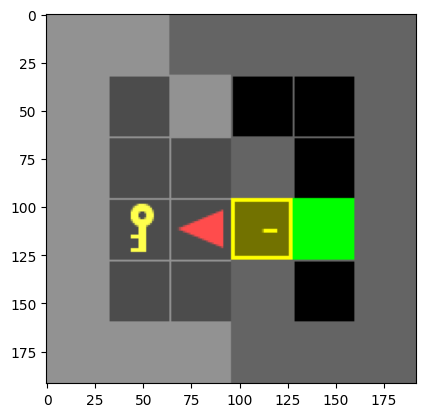

In [41]:
env_path = 'envs/known_envs/doorkey-6x6-shortcut.env'
env, info = load_env(env_path)
plot_env(env)
# trial_sequence = [MF, PK, TR, TR, UD, MF, MF, TL, MF, MF, MF]
# total_cost = 0
# state = [[1,1]]
# if(isinstance(env.unwrapped.carrying, Key)):
#     print(1)
# else:
#     print(0)
# # for action in trial_sequence:
# action = MF
# # step_cost, terminated , (obs, reward, terminated, truncated, info) = step(env, actions[action], state)
# step_cost = step(env, action, state, info['goal_pos'])
# total_cost += step_cost
# # if(isinstance(env.unwrapped.carrying, Key)):
# #     print(1)
# plot_env(env)
# print(total_cost, step_cost, state['terminated'], env.agent_pos ) #, (obs, reward, terminated, truncated, info))



## Part A

In [42]:
def make_motion_model_known(env_name, known = True):
    if known:
        env_path = 'envs/known_envs/' + env_name + '.env'
    else:
         env_path = 'envs/random_envs/' + env_name + '.env'
    env, info = load_env(env_path)
    layout = known_map_configs[env_name]['layout'] if known else None
    door_pos = info['door_pos']
    key_pos = info["key_pos"]
    goal = info['goal_pos']
    action_list = [MF, TL, TR, PK, UD]
    state_list = []
    pos_list = []
    f = {}
    c = {}
    # print(layout)
    if known:
        for i in range(layout.shape[0]):
            ii = i+1
            for j in range(layout.shape[1]):
                jj = j+1
                if layout[i,j] == WALL:
                    continue
                agent_pos = np.array([jj,ii])
                pos_list.append(agent_pos)
                for agent_dir in range(4):
                    for carrying_key in [False, True]:
                        for dooropen in [False, True]:
                            state = tuple((tuple(agent_pos), agent_dir, carrying_key, dooropen))
                            state_list.append(state)
                            f[state] = {}
                            c[state] = {}
                            for action in action_list:

                                env.unwrapped.agent_pos = agent_pos
                                env.unwrapped.agent_dir = agent_dir
                                if carrying_key :
                                    env.unwrapped.grid.set(key_pos[0], key_pos[1], None)
                                    env.unwrapped.carrying = Key(color='yellow')
                                else: 
                                    env.unwrapped.grid.set(key_pos[0], key_pos[1], Key('yellow'))
                                    env.unwrapped.carrying = None
                                if dooropen:
                                    env.unwrapped.grid.get(door_pos[0], door_pos[1]).is_open = True
                                    env.unwrapped.grid.get(door_pos[0], door_pos[1]).is_locked = False
                                else:
                                    env.unwrapped.grid.get(door_pos[0], door_pos[1]).is_open = False
                                    env.unwrapped.grid.get(door_pos[0], door_pos[1]).is_locked = True


                                cost = step(env, action, state, goal)
                                state_new = tuple((tuple(env.unwrapped.agent_pos), env.unwrapped.agent_dir , 
                                                                  isinstance(env.unwrapped.carrying, Key) , env.unwrapped.grid.get(door_pos[0], door_pos[1]).is_open))
                                f[state][action] = state_new
                                c[state][action] = cost
        return c, f, state_list, pos_list, action_list, info

# c, f, state_list, pos_list, action_list = make_motion_model('doorkey-6x6-shortcut', known = True)
# print(len(f.keys()), len(state_list), len(pos_list))
                        


In [31]:
def dp_known(env_name, known = True):
    V = {}
    policy = {}

    cost, f, state_list, _, action_list, info = make_motion_model_known(env_name, known = known)
    goal = info['goal_pos']
    

    T = len(state_list) - 1
    for t in range(T+1):
        V[t] = {}
        policy[t] = {}
        for state in state_list:
            if t == T :
                V[t][state] = 2*T
            if np.all(state[0] == goal):
                V[t][state] = 0
    
    for t in range(T-1, -1, -1):
        for state in state_list:
            V_min = np.inf
            u_min = 10
            for action in action_list:
                s_next = f[state][action]
                Q = cost[state][action] + V[t+1][s_next]
                if Q < V_min:
                    V_min = Q
                    u_min = action 
            V[t][state] = V_min
            policy[t][state] = u_min 
            
    agent_pos = info['init_agent_pos']
    agent_dir = info['init_agent_dir']
    carrying_key = False
    dooropen = False 
    state = tuple((tuple(agent_pos), agent_dir, carrying_key, dooropen))
    control_seq = []
    print(state)
    t= 0
    while not np.all(agent_pos == goal) and t < T:
        optim_action = policy[t][state]
        control_seq.append(optim_action)
        state = f[state][optim_action]
        agent_pos = state[0]
        t += 1
    
    return control_seq

((2, 1), 3, False, False)
[2, 0, 2, 3, 1, 4, 0, 0]


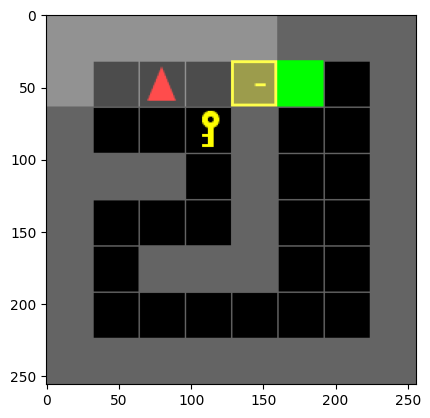

In [32]:
#@ One Example Run
env_name = 'doorkey-8x8-shortcut'
env_path = 'envs/known_envs/doorkey-8x8-shortcut.env'
control_seq = dp_known(env_name, known = True)
print(control_seq)
env, info = load_env(env_path)
plot_env(env)
goal = info['goal_pos']
door_pos = info['door_pos']
agent_dir = info['init_agent_dir']
agent_pos = info['init_agent_pos']
state = tuple((tuple(agent_pos), agent_dir, False, False))
# for action in control_seq:
    # print(action)
    # step(env, action, state, goal)
    # state = tuple((tuple(env.unwrapped.agent_pos), env.unwrapped.agent_dir , isinstance(env.unwrapped.carrying, Key) , env.unwrapped.grid.get(door_pos[0], door_pos[1]).is_open))
    # plot_env(env)

In [33]:
## Running for all
dirpath = "./envs/known_envs"
file_list = os.listdir(dirpath)
file_list = [file for file in file_list if file.endswith('env')]
file_dict = {}
for file in file_list:
    env_path = os.path.join(dirpath, file)
    env_name = file[:-4]
    print(env_name)
    control_seq = dp_known(env_name, known = True)
    env, info = load_env(env_path)
    print(control_seq)
    # plot_env(env)
    draw_gif_from_seq(control_seq, env,  path="./gif/" + env_name + ".gif")
    file_dict[file] = control_seq
    print('______________________________________')

doorkey-8x8-shortcut
((2, 1), 3, False, False)
[2, 0, 2, 3, 1, 4, 0, 0]
GIF is written to ./gif/doorkey-8x8-shortcut.gif
______________________________________
doorkey-8x8-direct
((2, 1), 1, False, False)
[0, 1, 0, 0, 0, 1, 0]
GIF is written to ./gif/doorkey-8x8-direct.gif
______________________________________
example-8x8
((2, 3), 0, False, False)
[2, 0, 3, 1, 4, 0, 0, 0, 0, 2, 0]
GIF is written to ./gif/example-8x8.gif
______________________________________
doorkey-6x6-normal
((1, 2), 2, False, False)
[1, 0, 3, 1, 0, 1, 0, 2, 4, 0, 0, 2, 0]
GIF is written to ./gif/doorkey-6x6-normal.gif
______________________________________
doorkey-6x6-direct
((2, 1), 0, False, False)
[0, 0, 2, 0, 0]
GIF is written to ./gif/doorkey-6x6-direct.gif
______________________________________
doorkey-6x6-shortcut
((2, 3), 2, False, False)
[3, 1, 1, 4, 0, 0]
GIF is written to ./gif/doorkey-6x6-shortcut.gif
______________________________________
doorkey-5x5-normal
((1, 2), 1, False, False)
[1, 1, 3, 2, 4, 0, 

# Part B - Random Environments

State =
pos
dir
key_loc
dooropen
key_pickup
goal_loc

In [34]:
key_loc_list = [(1,1),(2,3),(1,6)]
door_loc_list = [(4,2),(4,5)]
goal_loc_list = [(5,1),(6,3),(5,6)]

env, info,_ = load_random_env('./envs/random_envs/DoorKey-8x8-1.env')

In [35]:
def make_state_list_random(key_loc_list, door_loc_list, goal_loc_list):
    width = 8
    height = 8
    # goal_state_list = range(3)
    key_state_list = list(range(4))
    door_state_list = [(True, True), (True, False), (False, True), (False,False)]
    dir_state_list = list(range(4))
    pos_list = []
    state_list = []
    for i in range(width):
        for j in range(height):
            agent_pos = tuple((i,j))
            if isinstance(env.unwrapped.grid.get(i,j), Wall):
                continue
            pos_list.append(agent_pos)
            for agent_dir in dir_state_list:
                for key_state in key_state_list:
                    if key_state<3:
                        if np.all(agent_pos == key_loc_list[key_state]):
                            continue
                        
                    for door_state in door_state_list:
                        # for k in range(2):
                        if np.all(door_loc_list[1] == agent_pos) and door_state[1] == False:
                            continue
                        if np.all(door_loc_list[0] == agent_pos) and door_state[0] == False:
                            continue
                        for goal in goal_loc_list:
                            state = tuple((agent_pos, agent_dir, key_state, door_state, goal))
                            state_list.append(state)
    return pos_list, state_list
                            
                        

In [36]:
def make_motion_model_random(key_loc_list, door_loc_list, goal_loc_list):
    f = {}
    c = {}
    agent_dir_step_list = [(1,0), (0,1), (-1,0), (0,-1)]
    pos_list, state_list =  make_state_list_random(key_loc_list, door_loc_list, goal_loc_list)
    action_list = list(range(5))
    for state in state_list:
        f[state] = {}
        c[state] = {}
        for action in action_list:
            
            agent_pos = state[0]
            agent_dir = state[1]
            key_state = state[2]
            door_state = state[3]
            goal = state[4]
            key_loc = None if key_state == 3 else key_loc_list[key_state]

            agent_dir_step = agent_dir_step_list[agent_dir]
            next_pos = tuple(np.array(agent_pos) + np.array(agent_dir_step))
            if np.any(np.array(next_pos) < 0) or np.any(np.array(next_pos) > 7):
                cost = 1000
            else:
                cost = 1
            
            if np.all(agent_pos == goal):
                f[state][action] = state
                c[state][action] = 0
                continue
            if action == MF:
                if np.all(next_pos == door_loc_list[1]) and door_state[1] == False:
                    agent_pos = agent_pos
                elif np.all(next_pos == door_loc_list[0]) and door_state[0] == False:
                    agent_pos = agent_pos
                elif not next_pos in pos_list:
                    agent_pos = agent_pos
                elif key_loc and np.all(next_pos == key_loc):
                    agent_pos = agent_pos
                else :
                    agent_pos = next_pos

            if action == TL:
                agent_dir = (agent_dir -1)%4

            elif action == TR:
                agent_dir = (agent_dir +1)%4

            elif action == PK :
                if key_loc and np.all(key_loc == next_pos):
                    key_loc = None
                    key_state = 3

            elif action == UD:
                if next_pos in door_loc_list and key_state == 3:
                    door_num = door_loc_list.index(next_pos)
                    door_state_new = [True, True]
                    door_state_new[door_num] = not door_state[door_num]
                    door_state_new[1-door_num] = door_state[1-door_num]
                    door_state = tuple(door_state_new)
            state_new = tuple((agent_pos, agent_dir, key_state, door_state, goal))
            f[state][action] = state_new
            c[state][action] = cost
    return c, f, state_list, pos_list, action_list
            



In [13]:
from collections import defaultdict
def dp_random(key_loc_list, door_loc_list, goal_loc_list):

    cost, f, state_list, pos_list, action_list = make_motion_model_random(key_loc_list, door_loc_list, goal_loc_list)
    
    T = int(len(state_list)/(len(goal_loc_list) * 2) -1)
    T = len(state_list) - 1
    # print(T)
    # print(len(state_list))
    # print(len(goal_loc_list))
    V = {}
    policy = defaultdict(None)

    for state in state_list:
        if np.all(state[0] == state[4]):
            V[state] = 0
        else:
            V[state] = 10*T
        
    
    for t in range(T-1, -1, -1):
        print(t)
        
        stable_flag =1 
        for state in state_list:
            V_min = np.inf
            u_min = None
            for action in action_list:
                state_next = f[state][action]
                Q = cost[state][action] + V[state_next]
                if Q < V_min:
                    V_min = Q
                    u_min = action 
            if not (V[state] == V_min): 
                stable_flag = 0
            V[state] = V_min
            policy[state] = u_min
        if stable_flag == 1:
            break

    return V, policy, T, f

In [14]:
def find_path_random(env_name, f, policy, key_loc_list,goal_loc_list ,T):
    env, info, _  = load_random_env('./envs/random_envs/' + env_name )
    # plot_env(env)
    agent_pos = info['init_agent_pos']
    agent_pos = tuple(env.unwrapped.agent_pos)
    # agent_dir = info['init_agent_dir']
    agent_dir = env.unwrapped.agent_dir
    key_loc = tuple(info['key_pos'])
    if key_loc in key_loc_list:
        key_state = key_loc_list.index(tuple(key_loc))
    else:
        key_state = 3
    goal = tuple(info['goal_pos'])
    # goal_state = goal_loc_list.index(goal)
    door_state = tuple(info['door_open'])   
    # state = tuple((tuple(agent_pos), agent_dir, carrying_key, dooropen, goal))
    state = tuple((agent_pos, agent_dir, key_state, door_state, goal))
    control_seq = []
    print(state)
    t= 0
    while not np.all(agent_pos == goal) and t < T:
        optim_action = policy[state]
        control_seq.append(optim_action)
        state = f[state][optim_action]
        # print(state)
        agent_pos = state[0]
        t += 1
        # print(t)
    print(control_seq)
    print("___________________________________")
    return control_seq



In [15]:
V, policy , T, f= dp_random(key_loc_list, door_loc_list, goal_loc_list)

10798
10797
10796
10795
10794
10793
10792
10791
10790
10789
10788
10787
10786
10785
10784
10783


In [16]:
agent_dir = 0
agent_pos = tuple((3,5))
key_state = 0
door_state = (True, True)
state = tuple((agent_pos, agent_dir, key_state, door_state, goal))

In [17]:
env_name = 'DoorKey-8x8-1' + '.env'
env, info, _ = load_random_env('./envs/random_envs/' + env_name)
control_seq = find_path_random(env_name, f ,policy, key_loc_list,goal_loc_list ,T)
# control_seq

((3, 5), 3, 0, (True, True), (5, 1))
[0, 0, 0, 2, 0, 0, 1, 0]
___________________________________


In [19]:
# find_path_random('DoorKey-8x8-1', policy, key_loc_list,goal_loc_list, T)
dirpath = "./envs/random_envs"
file_list = os.listdir(dirpath)
file_list = [file for file in file_list if file.endswith('env')]
file_dict = {}
# print(file_list)
for file in file_list:
    # print(file_list)
    pass
    print(file)
    seq = find_path_random(file,  f ,policy, key_loc_list,goal_loc_list ,T)
    file_dict[file] = seq
    env, _, _ = load_random_env('./envs/random_envs/'+file)
    draw_gif_from_seq(seq, env,  path="./gif/" + file[:-4]+ ".gif")

DoorKey-8x8-15.env
((3, 5), 3, 1, (False, True), (5, 1))
[2, 0, 0, 1, 0, 0, 0, 0]
___________________________________
GIF is written to ./gif/DoorKey-8x8-15.gif
DoorKey-8x8-24.env
((3, 5), 3, 1, (False, False), (5, 6))
[0, 0, 1, 3, 1, 0, 0, 1, 4, 0, 0, 2, 0]
___________________________________
GIF is written to ./gif/DoorKey-8x8-24.gif
DoorKey-8x8-21.env
((3, 5), 3, 1, (True, True), (5, 6))
[2, 0, 0, 2, 0]
___________________________________
GIF is written to ./gif/DoorKey-8x8-21.gif
DoorKey-8x8-28.env
((3, 5), 3, 2, (False, False), (5, 1))
[1, 0, 0, 1, 3, 1, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0]
___________________________________
GIF is written to ./gif/DoorKey-8x8-28.gif
DoorKey-8x8-25.env
((3, 5), 3, 2, (True, True), (5, 1))
[0, 0, 0, 2, 0, 0, 1, 0]
___________________________________
GIF is written to ./gif/DoorKey-8x8-25.gif
DoorKey-8x8-27.env
((3, 5), 3, 2, (False, True), (5, 1))
[2, 0, 0, 1, 0, 0, 0, 0]
___________________________________
GIF is written to ./gif/DoorKey-8x8-27.gif
Door

In [37]:
# c, f, state_list, pos_list, action_list = make_motion_model_random(key_loc_list, door_loc_list, goal_loc_list)


In [18]:
# env_name = 'DoorKey-8x8-1'
# env, info, _ = load_random_env('./envs/random_envs/' + env_name ) #+ '.env')
# plot_env(env)

In [38]:
# # key_loc = key_loc_list[2]
# key_state = 3
# door_state = (False, False)
# goal = goal_loc_list[1]
# agent_dir = 0
# wall_list = [(4,0),(4,1),(4,3),(4,4),(4,6),(4,7)]
# action = 4
# for agent_dir in range(4):
#     for i in range(8):
#         for j in range(8):
#             agent_pos = tuple((i,j))
#             if agent_pos in wall_list:
#                 continue
#             state = tuple((agent_pos, agent_dir, key_state, door_state, goal))
#             if state not in state_list:
#                 continue
#             # agent_pos, action, next_state = 
#             print(f"{agent_pos}, || {agent_dir}, || {f[state][action][0]}, || {f[state][action][3]} ")
#     print("______________________________________________________")


In [80]:
# def make_motion_model_random():
#     env_name = 'DoorKey-8x8-1'
#     env_path = './envs/random_envs/' + env_name + '.env'
#     env, info, _ = load_random_env(env_path)

#     key_state_list = range(4)
#     key_loc_list = [(1,1),(2,3),(1,6)]

#     goal_loc_list = [(5,1),(6,3),(5,6)]
#     goal_state_list = range(3)
    
#     door_state_list = [(False, False), (False, True), (True, False),(True, True)]
#     door_loc_list = [(4,2), (4,5)]

#     action_list = [MF, TL, TR, PK, UD]
#     state_list = []
#     pos_list = []
#     f = {}
#     c = {}
#     # print(layout)
#     width = info['width']
#     height = info['height']
#     for i in range(height ):
#         ii = i
#         for j in range(width ):
#             jj = j
#             agent_pos = np.array([jj,ii])
#             ## Check for agent overlapping with wall 
#             if isinstance(env.unwrapped.grid.get(jj, ii), Wall):
#                 print(f"Wall = {jj},{ii}")
#                 continue
#             pos_list.append(agent_pos)
#             for agent_dir in range(4):
#                 for door_state in door_state_list:
#                     ## Check for agent and door overlap
#                     if door_state[1] == False:
#                         if np.all(agent_pos == door_loc_list[1]):
#                             continue
#                     if door_state[0] == False :
#                         if np.all(agent_pos == door_loc_list[0]):
#                             continue
#                     for key_state in key_state_list:
#                         ## Check for agent and key overlap
#                         if key_state < 3:
#                             if np.all(agent_pos == key_loc_list[key_state]):
#                                 continue
#                         for goal_state in goal_state_list:
#                             state = tuple((tuple(agent_pos), agent_dir, key_state, door_state, goal_state))
#                             state_list.append(state)
#                             f[state] = {}
#                             c[state] = {}
#                             for action in action_list:

#                                 ### Place key
#                                 for key_loc in key_loc_list:
#                                     env.unwrapped.grid.set(key_loc[0], key_loc[1], None)
#                                 if key_state < 3:
#                                     # carrying_key = False
#                                     key_loc = key_loc_list[key_state]
#                                     env.unwrapped.grid.set(key_loc[0], key_loc[1], Key('yellow'))
#                                     env.unwrapped.carrying = None
#                                 else:
#                                     # carrying_key = True
#                                     env.unwrapped.carrying = Key('yellow')

#                                 ### Set a goal position
#                                 for goal_loc in goal_loc_list:
#                                     env.unwrapped.grid.set(goal_loc[0], goal_loc[1], None)
#                                 goal = goal_loc_list[goal_state]
#                                 env.unwrapped.grid.set(goal[0], goal[1], Goal())

#                                 ### Seting up door
#                                 for k in [0,1]:
#                                     if door_state[k] == False:
#                                         env.unwrapped.grid.get(door_loc_list[k][0], door_loc_list[k][0]).is_open = False
#                                         env.unwrapped.grid.get(door_loc_list[k][0], door_loc_list[k][0]).is_locked = True
#                                     else: 
#                                         env.unwrapped.grid.get(door_loc_list[k][0], door_loc_list[k][0]).is_open = True
#                                         env.unwrapped.grid.get(door_loc_list[k][0], door_loc_list[k][0]).is_locked = False

#                                 ### Setting up agent pos and dir
#                                 env.unwrapped.agent_pos = agent_pos
#                                 env.unwrapped.agent_dir = agent_dir
#                                 # print('aaaaaaa')
#                                 # print(height)
#                                 # print(width)
#                                 # print(jj)
#                                 # print(ii)
#                                 # print(i)
#                                 # print(j)
#                                 # print(action)
#                                 # print(agent_dir)
#                                 # print(agent_pos)
#                                 # print(env.unwrapped.front_pos)

#                                 cost = step(env, action, state, goal)
#                                 agent_dir_new = env.unwrapped.agent_dir
#                                 agent_pos_new = tuple(env.unwrapped.agent_pos)
#                                 key_state_new = 3 if isinstance(env.unwrapped.carrying, Key) else key_state
#                                 door_state_new = (env.unwrapped.grid.get(door_loc_list[0][0], door_loc_list[0][1]).is_open  , env.unwrapped.grid.get(door_loc_list[1][0], door_loc_list[1][1]).is_open)
#                                 goal_state_new = goal_state
#                                 state_new = tuple((tuple(agent_pos_new), agent_dir_new, key_state_new, door_state_new, goal_state_new))
                                
#                                 f[state][action] = state_new
#                                 c[state][action] = cost
#     return c, f, state_list, pos_list, action_list, info

# # c, f, state_list, pos_list, action_list = make_motion_model('doorkey-6x6-shortcut', known = True)
# # print(len(f.keys()), len(state_list), len(pos_list))
# c, f, state_list, pos_list, action_list, info = make_motion_model_random()
# print(len(state_list))

In [ ]:
# def dp_random():
#     V = {}
#     policy = {}
#     env_name = 'DoorKey-8x8-1'
#     cost, f, state_list, _, action_list, info = make_motion_model_random()
#     # goal = info['goal_pos']
#     key_loc_list = [(1,1),(2,3),(1,6)]
#     env, info, _  = load_random_env('./envs/random_envs/' + env_name + '.env')
#     plot_env(env)

#     goal_loc_list = [(5,1),(6,3),(5,6)]

#     T = int(np.ceil(len(state_list)/3)) - 1
#     for t in range(T+1):
#         V[t] = {}
#         policy[t] = {}
#         for state in state_list:
#             goal = goal_loc_list[state[-1]]
#             if t == T :
#                 V[t][state] = 2*T
#             if np.all(state[0] == goal):
#                 V[t][state] = 0
    
#     for t in range(T-1, -1, -1):
#         print(t)
#         stable_flag = 1
#         for state in state_list:
#             V_min = np.inf
#             u_min = 10
#             for action in action_list:
#                 s_next = f[state][action]
#                 Q = cost[state][action] + V[t+1][s_next]
#                 if Q < V_min:
#                     V_min = Q
#                     u_min = action 
#             V[t][state] = V_min
#             if V[t][state] != V[t+1][state]:
#                 stable_flag= 0
#             policy[t][state] = u_min 
#         if stable_flag == 1:
#             break
        
#     return policy, V, key_loc_list, goal_loc_list, T
